In [1]:
import sys
sys.path.insert(0, "/home/katharina/vame_approach/VAME")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from vame.analysis.kinutils import KinVideo, create_grid_video
import os
from datetime import datetime
from vame.util.auxiliary import read_config
import logging
import re
from pathlib import Path
from IPython import display
from vame.analysis.visualize import create_aligned_mouse_video, create_pose_snipplet
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(asctime)s: %(message)s')


%reload_ext autoreload
%autoreload 2

Using CUDA
GPU active: True
GPU used: GeForce RTX 3090


## Load latent vectors

In [72]:
PROJECT_PATH = "/home/katharina/vame_approach/themis_tail_belly_align"

anchor_idx = 4000 # select a time point to find similar neighbors to

anchor_idx = int(335.6* 120) # standing mouse
anchor_idx = int(373.32 * 120) # walking mouse

SHOW_ALIGNED = True # if True create an aligned video to create snipplets from; otherwise use original video
min_dist_nn_factor = 1 # config["time_window"] * min_dist_nn_factor will define the min distance in time points between the anchor and between sampled neighbors
align_landmark_idx = [8,16] # landmarks to use for alignment of the videos

trained_models = [
    (datetime.strptime(element, "%m-%d-%Y-%H-%M"), element)
    for element in os.listdir(os.path.join(PROJECT_PATH, "model"))
]
# sort by time step
trained_models.sort(key=lambda x: x[0])
latest_model = trained_models[-1][-1]

config_file = os.path.join(PROJECT_PATH, "model", latest_model, "config.yaml")
config = read_config(config_file)
# select landmark file
landmark_file = config["video_sets"][0]
data_path = os.path.join(
        PROJECT_PATH,
        "results",
        latest_model,
        landmark_file,
        config["model_name"],
        "kmeans-" + str(config["n_init_kmeans"]),
    )
latent_vectors = np.load(
        os.path.join(data_path, "latent_vector_" + landmark_file + ".npy")
    )

In [73]:
# extract landmark data and names
landmarks_orig = pd.read_csv(
        os.path.join(PROJECT_PATH, "landmarks", landmark_file + ".csv"), header=[0, 1],
    )
column_names = landmarks_orig.columns
landmark_names = [col_name[0] for col_name in column_names if col_name[-1] == "x"]

landmark_data_file = os.path.join(
        PROJECT_PATH, "data", landmark_file, landmark_file + "-PE-seq.npy"
    )
landmark_data_aligned = np.load(landmark_data_file).T
# reshape to (N_samples, N_landmarks, 2)
landmark_data_aligned = landmark_data_aligned.reshape(landmark_data_aligned.shape[0], -1, 2)

/home/katharina/anaconda3/envs/venv_VAME/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Sample anchor latent embedding and visualize together with its nearest neighbors

In [74]:
window_start = max(0, anchor_idx - int(config["time_window"] * min_dist_nn_factor))
window_end = min(len(latent_vectors), anchor_idx + int(config["time_window"] * min_dist_nn_factor))
selected_latent_vector = latent_vectors[anchor_idx, :]

dist_orig = np.sqrt(np.sum((latent_vectors - selected_latent_vector.reshape(1,-1))**2, axis=1))

time_points = np.arange(0, latent_vectors.shape[0])
time_points = np.concatenate([time_points[0:window_start], time_points[window_end:-1]])
latent_vectors = np.concatenate([latent_vectors[0:window_start], latent_vectors[window_end:-1]])
# distances between each latent vector and the selected one excluding the distances of latent vectors corresponding to temporally close frames
dist = np.concatenate([dist_orig[0:window_start], dist_orig[window_end:-1]])

# select n neighbors, and enshure the neighbors are separated by a min time span
selected_neighbor_idx = []
while len(selected_neighbor_idx) < 8 and len(dist) > 0:
    n_idx = np.argmin(dist)
    selected_neighbor_idx.append(time_points[n_idx])
    # remove all distances close to the selected anchor
    is_far_away = np.abs(time_points - time_points[n_idx]) > int(config["time_window"] * min_dist_nn_factor)
    dist = dist[is_far_away]
    time_points = time_points[is_far_away]

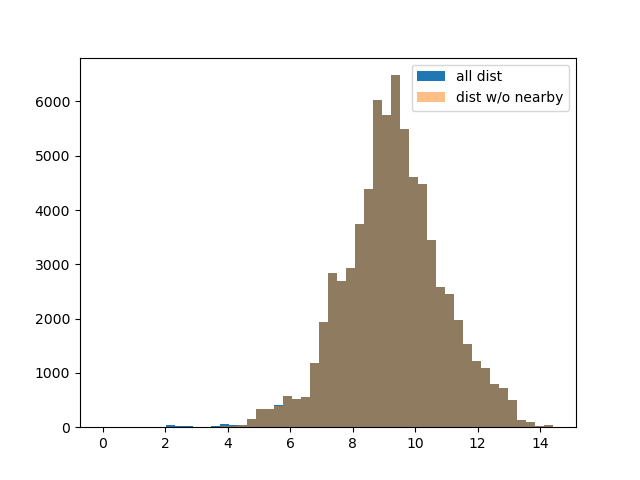

In [75]:
# Plot histogramm of distances
%matplotlib widget
# plot dist showing the neighbors but not the excluded ones?
# plotting dist removing only the nearby neighbors
bins = 50
hist_range = (min(dist_orig), max(dist_orig))
dist_wo_nearby = np.concatenate([dist_orig[0:window_start], dist_orig[window_end:-1]])
plt.hist(dist_orig,bins=bins, range=hist_range, label="all dist")
plt.hist(dist_wo_nearby, bins=bins, range=hist_range, alpha=0.5, label="dist w/o nearby")
plt.legend()

In [76]:
# get corresponding video
video_df = pd.read_csv(os.path.join(PROJECT_PATH, "video_info.csv"))
video_id = int(re.findall(r"\d+", landmark_file)[0])
video_file = os.path.join(
            *video_df[video_df["video_id"] == video_id][
                ["vid_folder", "vid_file"]
            ].values[0]
        )
subject, date, camera_pos, video_name = Path(video_file).parts[-4:]


In [77]:
# all selected time points including anchor and its nearest neighbors
time_ids = [anchor_idx, *selected_neighbor_idx]
# change from frames to seconds by dividing with fps
if SHOW_ALIGNED:
    video_name, ending = os.path.basename(video_file).split(".")
    aligned_video_path = os.path.join(
        PROJECT_PATH,
        "results", "align", "a" + video_name + "." + ending)
    if not os.path.exists(aligned_video_path):
        landmark_file_path = os.path.join(PROJECT_PATH, "landmarks", landmark_file+".csv")
        create_aligned_mouse_video(
            video_file,
            landmark_file,
            align_landmark_idx,
            os.path.dirname(aligned_video_path),
            crop_size=(300, 300))

    selected_video_file = aligned_video_path
else:
    selected_video_file = video_file
#print(selected_video_file)

video = KinVideo(selected_video_file, view=camera_pos)
video.probevid()
video_clip_duration = config["time_window"]/video.getfps()


video_clip_data = [(selected_video_file, t_id/ video.getfps(), (0,0,video.width,video.height)) for t_id in time_ids]
print(video_clip_data)
grid_video_name = create_grid_video(video_clip_data,video_clip_duration,speed=0.5) # duration is in seconds!!
display.Video(grid_video_name, embed=True,html_attributes="loop autoplay", width=600,height=600)


[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 373.31666666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 520.1666666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 374.53333333333336, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 302.65833333333336, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 316.15, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 248.025, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 309.35833333333335, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 81.84166666666667, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/

INFO: 2022-05-18 11:16:33,652: Scene 0 done (100%).
INFO: 2022-05-18 11:16:33,653: Concatenating 1 scenes.


In [78]:
## Visualize Anchor together with distant embeddings
# select other embeddings from the 
dist_percentile = 80

dist_thr = np.percentile(dist_orig, dist_percentile)

time_idx_other = np.where(dist_orig > dist_thr)[0].reshape(-1)
print(time_idx_other)
sampled_idx = np.random.choice(time_idx_other, 8, replace=False)
# select anchors
video_clip_data_distant = [(selected_video_file, t_id/ video.getfps(), (0,0,video.width,video.height)) for t_id in [anchor_idx, *sampled_idx]]
print(video_clip_data)
grid_video_name_distant = create_grid_video(video_clip_data_distant,video_clip_duration,speed=0.5) # duration is in seconds!!
display.Video(grid_video_name_distant, embed=True,html_attributes="loop autoplay", width=600,height=600)


[    0     1     2 ... 71935 71936 71937]
[('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 373.31666666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 520.1666666666666, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 374.53333333333336, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 302.65833333333336, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 316.15, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 248.025, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 309.35833333333335, (0, 0, 300, 300)), ('/home/katharina/vame_approach/themis_tail_belly_align/results/align/a0057.MP4', 81.84166666666667, (0, 0, 300, 300)), ('/home/kathar

INFO: 2022-05-18 11:17:04,260: Scene 0 done (100%).
INFO: 2022-05-18 11:17:04,261: Concatenating 1 scenes.


In [79]:
from ipywidgets import Output, GridspecLayout
grid = GridspecLayout(1, 2)

# sorted video files
video_files = [grid_video_name, grid_video_name_distant]
for i_vid, video_f in enumerate(video_files):
    out = Output()
    with out:
        display.display(display.Video(video_f, embed=True, html_attributes="loop autoplay", width=450,height=450))
    grid[0,i_vid] = out
grid


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [57]:
## create full pose video and then sample the snipplets
video_name = os.path.basename(video_file)
pose_video_file = os.path.join(PROJECT_PATH, "results", "poses_"+video_name)
if not os.path.exists(pose_video_file):
    crop_size = 400
    # min max normalize the data to a fixed grid shape for visualization
    landmark_name = os.path.basename(landmark_file).split(".")[0]
    # reshape to (N_samples, N_landmarks, 2)
    landmark_data_aligned = np.load(
        os.path.join(PROJECT_PATH, "data", landmark_name, landmark_name + "-PE-seq.npy")
    ).T
    landmark_data_aligned = landmark_data_aligned.reshape(
        landmark_data_aligned.shape[0], -1, 2
    )
    landmark_data_trafo = (
        (landmark_data_aligned - landmark_data_aligned.min())
        / (landmark_data_aligned.max() - landmark_data_aligned.min())
        * (crop_size - 1)
    )
    column_names = pd.read_csv(landmark_file, header=[0, 1]).columns
    landmark_names = [col_name[0] for col_name in column_names if col_name[-1] == "x"]
    time_ids = np.arange(0, len(landmark_data_trafo))
    create_pose_snipplet(
        landmark_data_trafo,
        landmark_names,
        time_ids,
        pose_video_file,
        crop_size=(crop_size, crop_size),
    )
pose_video = KinVideo(pose_video_file, view=camera_pos)
pose_video.probevid()

pose_video_clip_data = [(pose_video_file, t_id/ pose_video.getfps(), (0,0,pose_video.width,pose_video.height)) for t_id in time_ids]
pose_grid_video_name = create_grid_video(pose_video_clip_data,video_clip_duration,speed=0.5) # duration is in seconds!!
display.Video(pose_grid_video_name, embed=True,html_attributes="loop autoplay", width=900,height=900)


INFO: 2022-05-18 11:12:02,853: Scene 0 done (100%).
INFO: 2022-05-18 11:12:02,854: Concatenating 1 scenes.


## T.SNE of latent space

In [ ]:
from sklearn.manifold import TSNE
latent_vectors_all = np.load(
        os.path.join(data_path, "latent_vector_" + landmark_file + ".npy")
    )
tsne = TSNE(perplexity=30).fit_transform(latent_vectors_all)

In [ ]:
%matplotlib widget
is_neighbor_id = np.isin(np.arange(0,tsne.shape[0]), time_ids[1:])

plt.plot (tsne[:, 0], tsne[:, 1], 'r.', label='TSNE')
plt.plot (tsne[anchor_id, 0], tsne[anchor_id, 1], 'bo', label='Anchor')
plt.plot (tsne[is_neighbor_id, 0], tsne[is_neighbor_id, 1], 'yo', label='Neighbors')
plt.legend()

In [ ]:
# the small paths are the latent vectors corresponding to time series which are very close to the initial time series
# since t-SNE tries to preserve the local neighborhood it will prioritize embedding the direct neighbors over embedding
# quite similar time series of later frames -> therefore test how the projection looks on a subsampled data set
n_fraction = 0.05
rand_sub_set = np.random.choice(np.arange(0, latent_vectors_all.shape[0]), int(n_fraction*latent_vectors_all.shape[0]),replace=False)
tsne_sub = TSNE(perplexity=30).fit_transform(latent_vectors_all[rand_sub_set])

In [ ]:
%matplotlib widget
is_neighbor_id = np.isin(rand_sub_set, time_ids[1:])

plt.plot (tsne_sub[:, 0], tsne_sub[:, 1], 'r.', label='TSNE sub')
if np.isin(anchor_id, rand_sub_set):
    plt.plot (tsne_sub[anchor_id, 0], tsne_sub[anchor_id, 1], 'bo', label='Anchor')
plt.plot (tsne_sub[is_neighbor_id, 0], tsne_sub[is_neighbor_id, 1], 'yo', label='Neighbors')
plt.legend()

In [ ]:
## Mark time windows with little and strong movement (lower and upper N% percentiles)

In [ ]:
## Mark time windows with little and strong movement (lower and upper N% percentiles)

In [ ]:
# visualize time points with high motility
# idea: calc sum of differences in the tailbase - because when the rat is getting 
# up the tailbase will also remain constant
# use the non aligned data 
print(landmarks_orig.shape)
tailbase_pos = landmarks_orig[[("tailbase","x"), ("tailbase","y")]][1:]
tailbase_diff = tailbase_pos.diff(periods=1)
tailbase_shift = (tailbase_diff[("tailbase", "x")]**2 + tailbase_diff[("tailbase", "y")]**2)**0.5

In [ ]:
# calc per window the sum of position changes
total_vel = [np.sum(tailbase_shift[i:i+config["time_window"]]) for i in rand_sub_set]
total_vel = np.array(total_vel)
print(total_vel.shape)

In [ ]:
# select slowest 20% as resting; fastest 20% as walking
slow_percentile = np.percentile(total_vel, 20)
fast_percentile = np.percentile(total_vel, 80)
print(f"Lower percentile {slow_percentile}; upper percentile {fast_percentile}")

In [ ]:
%matplotlib widget
slow_time_points = total_vel < slow_percentile
fast_time_points = total_vel > fast_percentile
print(len(fast_time_points))
print(tsne_sub.shape)
# plot s
plt.plot (tsne_sub[:, 0], tsne_sub[:, 1], 'r.', label='t.SNE')
plt.plot (tsne_sub [fast_time_points, 0], tsne_sub [fast_time_points, 1], 'b.', label='Fast')
plt.plot (tsne_sub [slow_time_points, 0], tsne_sub [slow_time_points, 1], 'y.', label='Slow')
plt.legend ()
